In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [2]:
genres = list(os.listdir('./Data/genres_original/'))
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [3]:
# Discard filename and length as it gives no information
dataset = pd.read_csv('./Data/features_3_sec.csv').iloc[0:, 2:]
dataset

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


The more data, the better: 9990 instances compared to the 1000 spectrograms. (even if it might seem that 3 sec windows should not model properly the entire genre)

In [4]:
Y = dataset['label']
X = dataset.loc[:, dataset.columns != 'label']

# Normalize X
cols = X.columns
scaler = MinMaxScaler()
scaled_input = scaler.fit_transform(X)
X = pd.DataFrame(scaled_input, columns=cols)

pca = PCA()
principalComponents = pca.fit_transform(X)
principalComponents

array([[-2.42167489e-01, -1.21146568e-01,  7.10578867e-02, ...,
         1.18390705e-03,  9.52651931e-03, -3.28520507e-03],
       [-2.76061511e-01, -2.30291076e-01,  3.89865026e-02, ...,
         9.48647476e-03,  1.70283409e-03, -2.20208787e-03],
       [-1.90024313e-01, -1.19509282e-01,  6.75024037e-02, ...,
        -4.41309670e-04,  4.37235105e-03,  6.74660068e-04],
       ...,
       [-3.90216144e-01,  1.97885066e-01,  2.41838033e-01, ...,
         3.13751676e-02,  6.76318673e-05, -4.70167792e-04],
       [-3.10315416e-01, -3.88161635e-01, -3.05371785e-02, ...,
         2.10508378e-02, -4.78099456e-03, -5.60159539e-04],
       [-3.77906170e-01, -1.06448613e-01,  8.74728597e-02, ...,
         1.38730425e-02, -8.02431982e-03,  6.81585391e-03]])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(principalComponents, Y, random_state=42, stratify=Y, test_size=0.2)
X_train

array([[ 2.76704759e-01,  2.53341184e-01,  1.69727166e-01, ...,
        -7.25610360e-03,  1.72332723e-02,  1.27894556e-03],
       [-7.66803327e-02, -5.65957157e-01, -4.54864618e-02, ...,
         5.77636063e-03,  5.55863473e-04,  4.12496225e-04],
       [ 5.72488937e-01,  4.95094153e-02, -3.47350225e-01, ...,
        -7.41733364e-03, -5.84386485e-03,  5.00470507e-04],
       ...,
       [-3.85289008e-01,  1.41972388e-01,  9.50765902e-02, ...,
        -4.48682840e-05,  5.17358739e-03, -2.50896887e-03],
       [-3.24527679e-01, -1.73609289e-01,  8.29812495e-02, ...,
         8.02360555e-03, -5.04756466e-04,  1.98385419e-03],
       [ 4.31244181e-01, -5.28724927e-02, -3.03363013e-01, ...,
        -7.66138219e-03, -1.36765477e-02, -5.20534759e-03]])

# Dataset with full length audio

In [3]:
# Discard filename and length as it gives no information
dataset = pd.read_csv('./Data/features_30_sec.csv').iloc[0:, 2:]
dataset

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [4]:
Y = dataset['label']
X = dataset.loc[:, dataset.columns != 'label']

# Normalize X
cols = X.columns
scaler = MinMaxScaler()
scaled_input = scaler.fit_transform(X)
X = pd.DataFrame(scaled_input, columns=cols)

pca = PCA()
principalComponents = pca.fit_transform(X)
principalComponents

array([[-3.94211703e-01, -1.16144926e-01, -9.98054380e-02, ...,
         7.05165761e-03, -6.04733885e-04,  7.37407803e-04],
       [ 5.20187372e-02, -2.70757254e-01,  4.27636674e-01, ...,
         4.60594734e-03,  1.54930532e-02,  1.79221520e-03],
       [-4.79183815e-01, -2.24615950e-01, -1.42946226e-02, ...,
         9.44150225e-03, -1.50864919e-02,  1.21347719e-02],
       ...,
       [-8.45324172e-01, -7.20162381e-03, -1.10543279e-01, ...,
         1.04379605e-02,  1.15854744e-03, -1.64997914e-03],
       [-2.34261649e-01, -3.72665633e-01,  1.37527264e-01, ...,
         1.12835743e-02, -4.18697963e-03,  4.49336878e-04],
       [-3.99060275e-01, -2.76560924e-01,  1.87228798e-01, ...,
         2.12671214e-02,  7.83271351e-03,  2.92997450e-03]])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(principalComponents, Y, random_state=42, stratify=Y, test_size=0.2)
X_train

array([[ 0.30446592,  0.14336231, -0.67873338, ..., -0.02462243,
         0.00657118,  0.00174522],
       [ 0.10616853,  0.49823001, -0.49480197, ..., -0.0118855 ,
         0.02632502,  0.01069283],
       [-0.65013524, -0.01449958, -0.0497728 , ..., -0.00809178,
        -0.0009197 ,  0.00309405],
       ...,
       [ 0.19033734,  0.24557123, -0.21781254, ...,  0.01797345,
        -0.00505196,  0.00403117],
       [ 0.01529569,  0.41267751, -0.3498908 , ..., -0.00083882,
        -0.00194666, -0.00810892],
       [-0.36091572, -0.06200691,  0.08579027, ..., -0.0053079 ,
         0.00337512, -0.00094521]])

### KNN

In [8]:
pipeline = Pipeline([('knn', KNeighborsClassifier())])

param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Best parameters: {'knn__n_neighbors': 1}
Best score: 0.9195454605937222


In [9]:
model.score(X_test, y_test)

0.9169169169169169

In [10]:
y_pred = model.predict(X_test)
y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'hiphop', 'metal'],
      dtype=object)

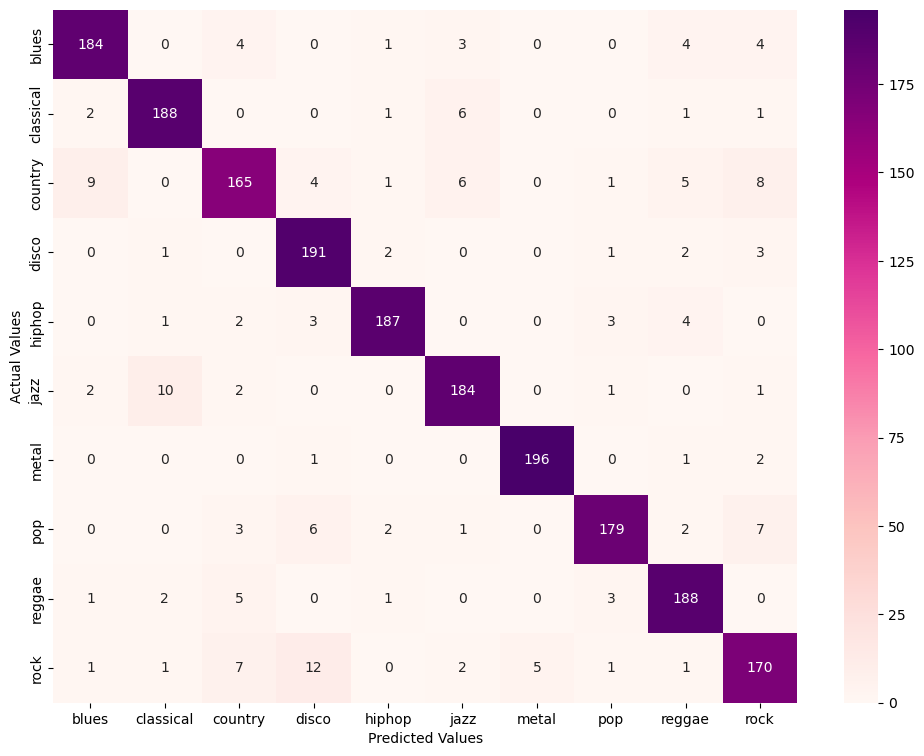

In [11]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/KNN_confusion_matrix.png', bbox_inches='tight')

In [12]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.92      0.92      0.92       200
   classical       0.93      0.94      0.94       199
     country       0.88      0.83      0.85       199
       disco       0.88      0.95      0.92       200
      hiphop       0.96      0.94      0.95       200
        jazz       0.91      0.92      0.92       200
       metal       0.98      0.98      0.98       200
         pop       0.95      0.90      0.92       200
      reggae       0.90      0.94      0.92       200
        rock       0.87      0.85      0.86       200

    accuracy                           0.92      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.92      0.92      0.92      1998



### SVM

In [13]:
pipeline = Pipeline([('svm', SVC())])

param_grid = {
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best score: 0.9076583377752522


In [14]:
model.score(X_test, y_test)

0.9124124124124124

In [15]:
y_pred = model.predict(X_test)
y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'hiphop', 'metal'],
      dtype=object)

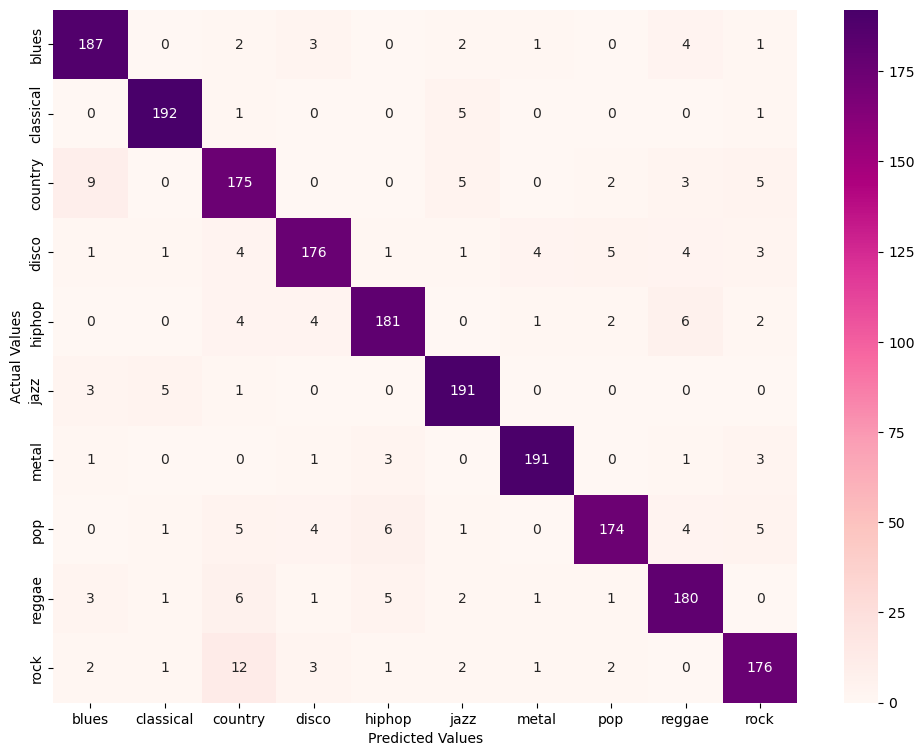

In [16]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/SVM_confusion_matrix.png', bbox_inches='tight')

In [17]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.91      0.94      0.92       200
   classical       0.96      0.96      0.96       199
     country       0.83      0.88      0.86       199
       disco       0.92      0.88      0.90       200
      hiphop       0.92      0.91      0.91       200
        jazz       0.91      0.95      0.93       200
       metal       0.96      0.95      0.96       200
         pop       0.94      0.87      0.90       200
      reggae       0.89      0.90      0.90       200
        rock       0.90      0.88      0.89       200

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



# Random Forest

In [18]:
pipeline = Pipeline([('rf', RandomForestClassifier())])

param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best score: 0.8494749143120582


In [19]:
model.score(X_test, y_test)

0.8673673673673674

In [20]:
y_pred = model.predict(X_test)
y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'hiphop', 'metal'],
      dtype=object)

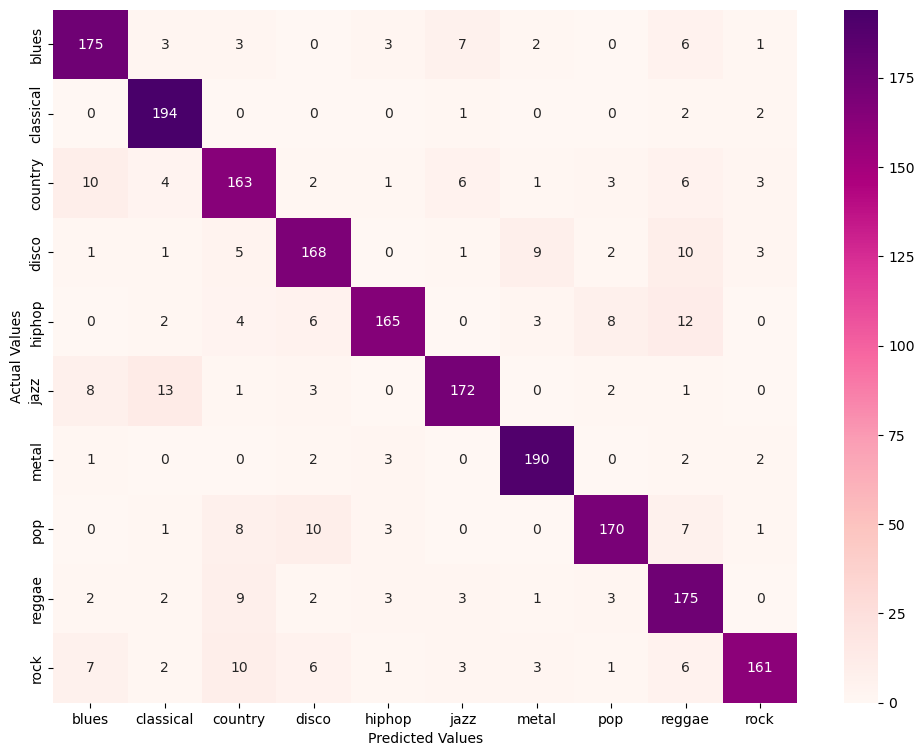

In [21]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/RandomForest_confusion_matrix.png', bbox_inches='tight')

In [22]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.86      0.88      0.87       200
   classical       0.87      0.97      0.92       199
     country       0.80      0.82      0.81       199
       disco       0.84      0.84      0.84       200
      hiphop       0.92      0.82      0.87       200
        jazz       0.89      0.86      0.88       200
       metal       0.91      0.95      0.93       200
         pop       0.90      0.85      0.87       200
      reggae       0.77      0.88      0.82       200
        rock       0.93      0.81      0.86       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



### Logistic Regression

In [24]:
pipeline = Pipeline([('logreg', LogisticRegression())])

param_grid = [
    {
        'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'logreg__C': [1e-4, 1e-2, 1, 1e2],
        'logreg__solver': ['saga']
    },
    {
        'logreg__penalty': ['l2', 'none'],
        'logreg__C': [1e-4, 1e-2, 1, 1e2],
        'logreg__solver': ['newton-cg', 'lbfgs', 'sag']
    },
    {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': [1e-4, 1e-2, 1, 1e2],
        'logreg__solver': ['liblinear']
    }
]

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbos

Best parameters: {'logreg__C': 0.0001, 'logreg__penalty': 'none', 'logreg__solver': 'sag'}
Best score: 0.7199683625795533


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [25]:
model.score(X_test, y_test)

0.7232232232232232

In [26]:
Y_pred = model.predict(X_test)
Y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'pop', 'metal'],
      dtype=object)

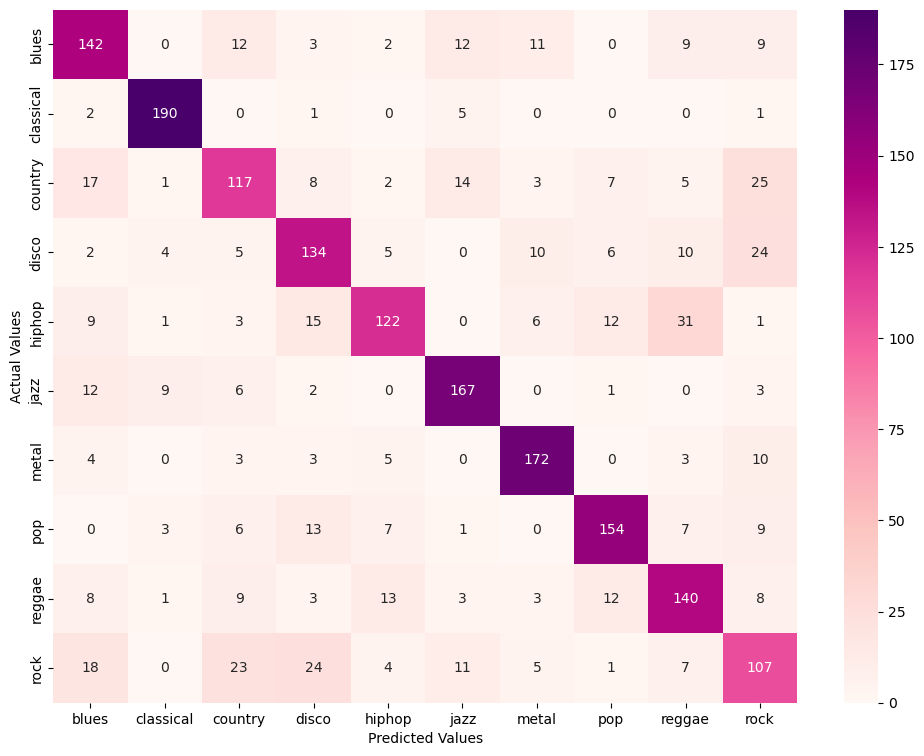

In [27]:
cm = confusion_matrix(y_test, Y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/LogisticRegression_confusion_matrix.png', bbox_inches='tight')

In [28]:
print(classification_report(y_test, Y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.66      0.71      0.69       200
   classical       0.91      0.95      0.93       199
     country       0.64      0.59      0.61       199
       disco       0.65      0.67      0.66       200
      hiphop       0.76      0.61      0.68       200
        jazz       0.78      0.83      0.81       200
       metal       0.82      0.86      0.84       200
         pop       0.80      0.77      0.78       200
      reggae       0.66      0.70      0.68       200
        rock       0.54      0.54      0.54       200

    accuracy                           0.72      1998
   macro avg       0.72      0.72      0.72      1998
weighted avg       0.72      0.72      0.72      1998



### Naive Bayes

In [29]:
pipeline = Pipeline([('nb', GaussianNB())])

param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'nb__var_smoothing': 1e-06}
Best score: 0.5128878264810375


In [30]:
model.score(X_test, y_test)

0.5005005005005005

In [31]:
Y_pred = model.predict(X_test)
Y_pred

array(['country', 'blues', 'classical', ..., 'disco', 'pop', 'metal'],
      dtype='<U9')

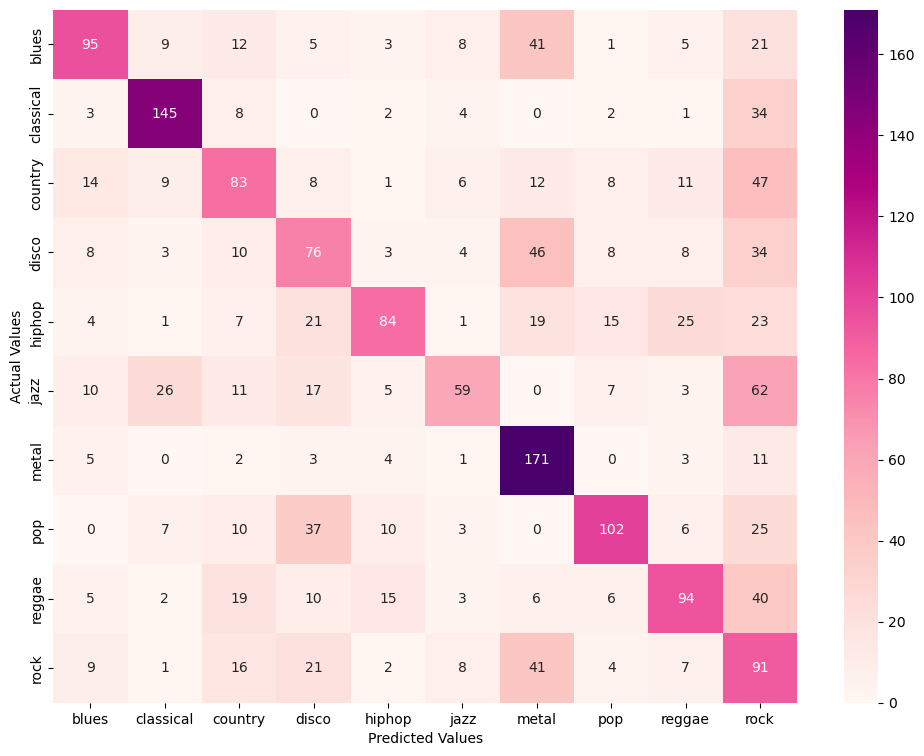

In [32]:
cm = confusion_matrix(y_test, Y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/NaiveBayes_confusion_matrix.png', bbox_inches='tight')

In [33]:
print(classification_report(y_test, Y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.62      0.47      0.54       200
   classical       0.71      0.73      0.72       199
     country       0.47      0.42      0.44       199
       disco       0.38      0.38      0.38       200
      hiphop       0.65      0.42      0.51       200
        jazz       0.61      0.29      0.40       200
       metal       0.51      0.85      0.64       200
         pop       0.67      0.51      0.58       200
      reggae       0.58      0.47      0.52       200
        rock       0.23      0.46      0.31       200

    accuracy                           0.50      1998
   macro avg       0.54      0.50      0.50      1998
weighted avg       0.54      0.50      0.50      1998



### XGBoost

In [35]:
encoder = LabelEncoder()
encoder.fit_transform(y_train)

array([4, 6, 7, ..., 0, 2, 2])

In [36]:
pipeline = Pipeline([('xgb', XGBClassifier())])

param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.1, 0.01, 0.001]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, encoder.fit_transform(y_train))

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}
Best score: 0.8509754610398709


In [37]:
model.score(X_test, encoder.fit_transform(y_test))

0.8663663663663663

In [38]:
Y_pred = model.predict(X_test)
Y_pred

array([2, 0, 1, ..., 6, 4, 6], dtype=int64)

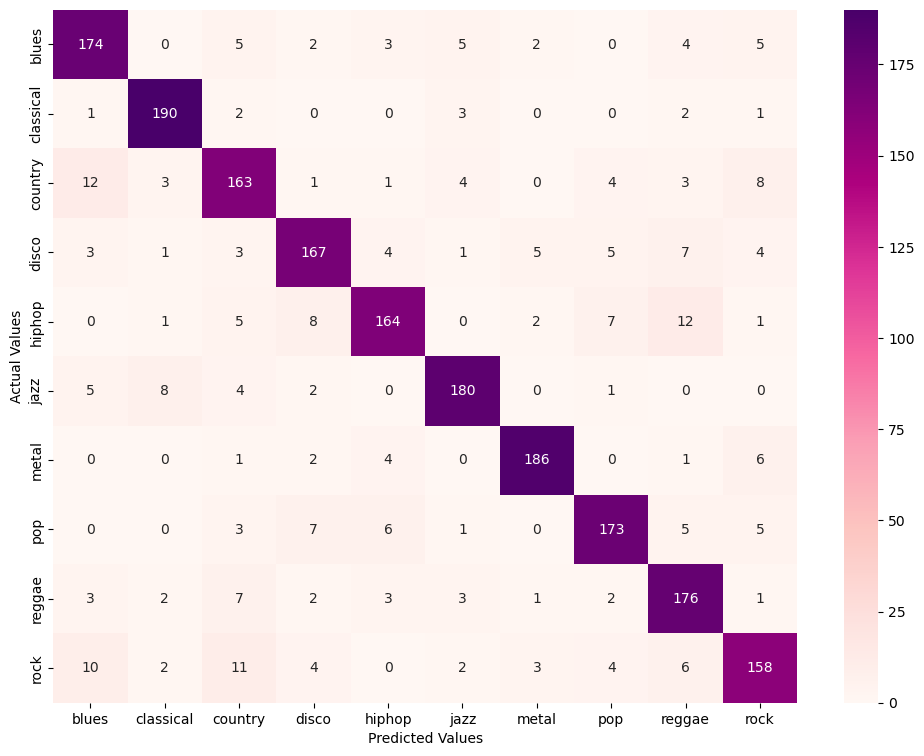

In [39]:
cm = confusion_matrix(encoder.fit_transform(y_test), Y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/XGB_confusion_matrix.png', bbox_inches='tight')

In [40]:
print(classification_report(encoder.fit_transform(y_test), Y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.84      0.87      0.85       200
   classical       0.92      0.95      0.94       199
     country       0.80      0.82      0.81       199
       disco       0.86      0.83      0.85       200
      hiphop       0.89      0.82      0.85       200
        jazz       0.90      0.90      0.90       200
       metal       0.93      0.93      0.93       200
         pop       0.88      0.86      0.87       200
      reggae       0.81      0.88      0.85       200
        rock       0.84      0.79      0.81       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



### Ensemble

In [41]:
from sklearn.ensemble import VotingClassifier

In [49]:
knn = KNeighborsClassifier()
svm = SVC(probability=True)
rf = RandomForestClassifier()
log = LogisticRegression(max_iter=1000)
nb = GaussianNB()
xgb = XGBClassifier(eval_metric='mlogloss')

model = VotingClassifier(
    estimators=[
        ('knn', knn),
        ('svm', svm),
        ('random forest', rf),
        ('logistic', log),
        ('naive bayes', nb),
        ('xgboost', xgb)
    ],
    voting='soft'
)

model.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm', SVC(probability=True)),
                             ('random forest', RandomForestClassifier()),
                             ('logistic', LogisticRegression(max_iter=1000)),
                             ('naive bayes', GaussianNB()),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_s...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft')

In [50]:
model.score(X_test, y_test)

0.8818818818818819

In [51]:
Y_pred = model.predict(X_test)
Y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'hiphop', 'metal'],
      dtype=object)

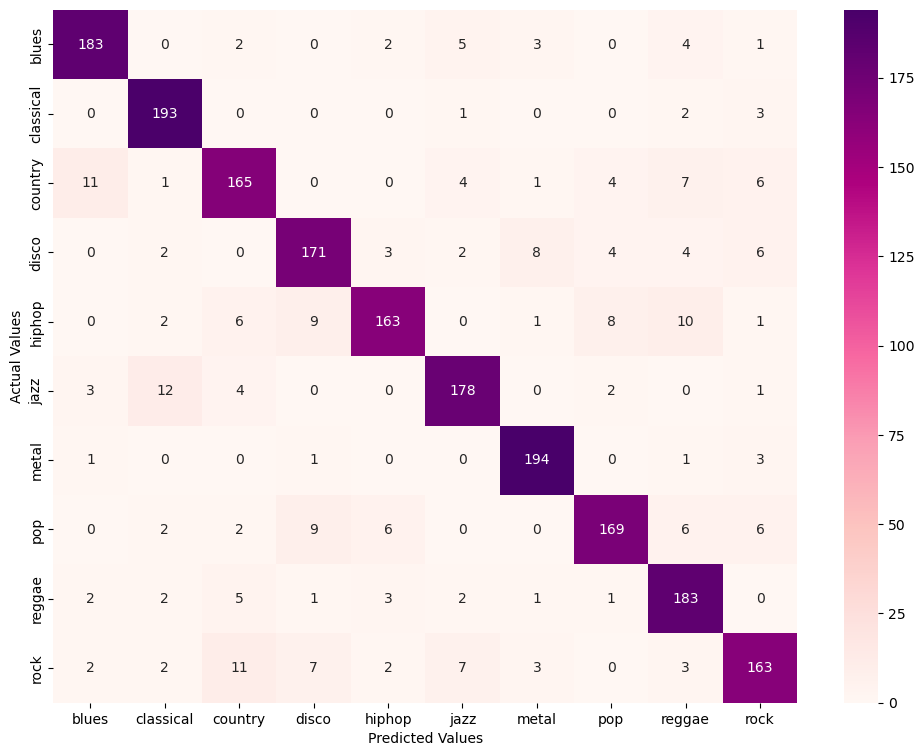

In [52]:
cm = confusion_matrix(y_test, Y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/ensemble_confusion_matrix.png', bbox_inches='tight')

In [53]:
print(classification_report(y_test, Y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.91      0.92      0.91       200
   classical       0.89      0.97      0.93       199
     country       0.85      0.83      0.84       199
       disco       0.86      0.85      0.86       200
      hiphop       0.91      0.81      0.86       200
        jazz       0.89      0.89      0.89       200
       metal       0.92      0.97      0.94       200
         pop       0.90      0.84      0.87       200
      reggae       0.83      0.92      0.87       200
        rock       0.86      0.81      0.84       200

    accuracy                           0.88      1998
   macro avg       0.88      0.88      0.88      1998
weighted avg       0.88      0.88      0.88      1998



In [6]:
from sklearn.ensemble import StackingClassifier

In [7]:
models_list = list()
models_list.append(('lr', LogisticRegression()))
models_list.append(('knn', KNeighborsClassifier()))
models_list.append(('svm', SVC()))
models_list.append(('rf', RandomForestClassifier()))
models_list.append(('nb', GaussianNB()))
models_list.append(('xgb', XGBClassifier(eval_metric='mlogloss')))

model = StackingClassifier(estimators=models_list, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)

model.fit(X_train, y_train)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier()), ('svm', SVC()),
                               ('rf', RandomForestClassifier()),
                               ('nb', GaussianNB()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [8]:
model.score(X_test, y_test)

0.9214214214214215

In [9]:
Y_pred = model.predict(X_test)
Y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'hiphop', 'metal'],
      dtype=object)

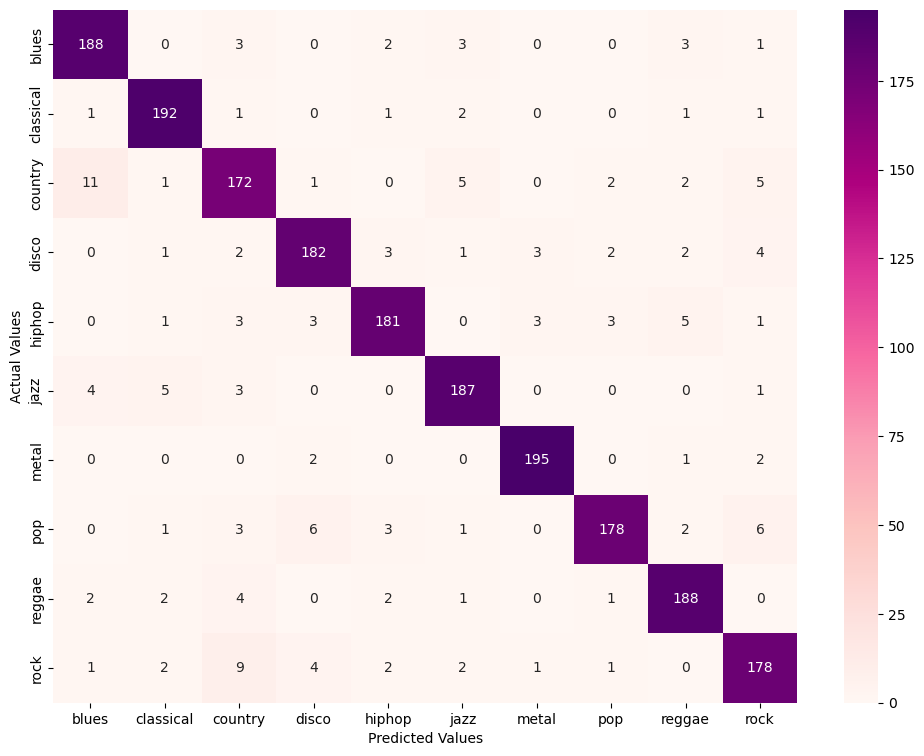

In [10]:
cm = confusion_matrix(y_test, Y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/ensemblestack_confusion_matrix.png', bbox_inches='tight')

In [11]:
print(classification_report(y_test, Y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.91      0.94      0.92       200
   classical       0.94      0.96      0.95       199
     country       0.86      0.86      0.86       199
       disco       0.92      0.91      0.91       200
      hiphop       0.93      0.91      0.92       200
        jazz       0.93      0.94      0.93       200
       metal       0.97      0.97      0.97       200
         pop       0.95      0.89      0.92       200
      reggae       0.92      0.94      0.93       200
        rock       0.89      0.89      0.89       200

    accuracy                           0.92      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.92      0.92      0.92      1998

